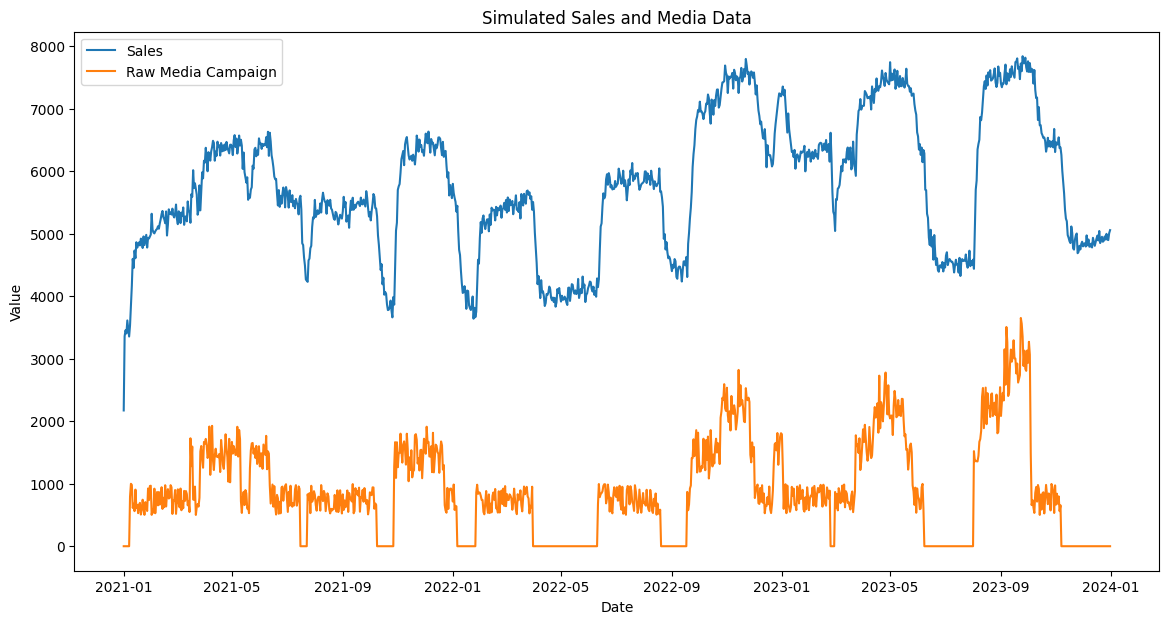

,Date,Sales,Raw_Media_Campaign,Time_Varying_Intercept
0,2021-01-01,2172.424512,0.0,1000.000000
1,2021-01-02,3360.014941,0.0,1001.372264
2,2021-01-03,3455.802618,0.0,1002.744528
3,2021-01-04,3404.073311,0.0,1004.116791
4,2021-01-05,3612.523524,0.0,1005.489055


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize parameters
N = 365 * 3  # Number of days (e.g., 3 years)
dates = pd.date_range("2021-01-01", periods=N, freq="D")

# Time-varying parameters with slight growth
fixed_coefficient = np.mean(1 + 0.2 * np.sin(np.linspace(0, 2*np.pi, N) * 2) + np.linspace(0, 1, N))
time_varying_intercept = 1000 + 0.2 * np.sin(np.linspace(0, 2*np.pi, N)) + np.linspace(0, 1500, N)

# Media parameters
decay_rate = 0.8  # Adstock decay rate
max_impact = 3000  # Saturation level
max_lag = 30  # Maximum lag impact

# Generate random media campaigns, let's say 20 campaigns
n_campaigns = 20
campaign_starts = np.random.choice(np.arange(0, N-60), n_campaigns)
campaign_starts.sort()
campaign_effects = np.zeros(N)

# Add media effects from each campaign
for start in campaign_starts:
    length = np.random.randint(8, 12) * 7  # Random campaign length between 8 to 12 weeks
    for i in range(0, length):
        if start + i < N:
            campaign_effects[start + i] += np.random.randint(500, 1000)

# Corrected Adstock and saturation
media_impact = np.zeros(N)
for i in range(1, N):
    for lag in range(1, min(i, max_lag) + 1):
        media_impact[i] += (decay_rate ** lag) * campaign_effects[i - lag]
        
    media_impact[i] = max_impact / (1 + np.exp(-0.0005 * (media_impact[i] - max_impact / 2)))

# Seasonality and noise
seasonality = 200 * np.sin(np.linspace(0, 2*np.pi, N) * 2)
noise = np.random.normal(0, 100, N)

# Final sales: time-varying intercept + seasonality + noise + media_impact * fixed_coefficient
sales = 1000 + time_varying_intercept + seasonality + noise + media_impact * fixed_coefficient

# Create DataFrame
df = pd.DataFrame({
    'Date': dates,
    'Sales': sales,
    'Raw_Media_Campaign': campaign_effects,
    'Time_Varying_Intercept': time_varying_intercept
})

# Plot data
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Sales'], label='Sales')
plt.plot(df['Date'], df['Raw_Media_Campaign'], label='Raw Media Campaign')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Simulated Sales and Media Data')
plt.show()

# Show first few rows of the DataFrame
df.head()

In [2]:
import pymc as pm
import pytensor.tensor as pt
import pymc.sampling_jax
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# Create a coordinate system based on dates
coords = {"Date": df["Date"].values}

# Transform 'Date' to numerical format: days since the first date
df['DateDays'] = (df['Date'] - df['Date'].min()).dt.days


# Begin probabilistic modeling
with pm.Model(coords=coords) as model:
    # Initial setup for the Gaussian Process
    eta = pm.Exponential("eta", lam=1)
    
    # Define constraints for the length scale of our GP. 
    # The length scale represents our belief on how quickly the base changes between time points/
    ell_params = pm.find_constrained_prior(
        pm.InverseGamma, 
        lower=75, upper=200, 
        init_guess={"alpha": 2, "beta": 20},
        mass=0.95,
    )
    ell = pm.InverseGamma("ell", **ell_params)
    
    # Define the covariance function
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    
    # Establish the Gaussian Process
    gp = pm.gp.HSGP(m=[40], c=2.0, cov_func=cov)
    f = gp.prior("f", X=df['DateDays'].values[:, None], dims="Date")
    
    # Estimate the average sales
    intercept = pm.Normal("intercept", mu=df["Sales"].mean(), sigma=2 * df["Sales"].std())
    
    # Model the media effect
    media_coef = pm.HalfNormal("media_coef", sigma=100)
    lam = pm.Gamma('lam', alpha=1, beta=1)
    alpha = pm.Beta('alpha', alpha=1, beta=1)

    media_impact = pm.Deterministic(
        "media_impact",
        media_coef * 
        logistic_saturation(
            geometric_adstock(df["Raw_Media_Campaign"], alpha=alpha, normalize=True, l_max=30),
            lam=lam
        )
    )
    # Combine effects
    base_prediction = pm.Deterministic("base_prediction", intercept + f, dims="Date")
    mu = pm.Deterministic("mu", base_prediction + media_impact, dims="Date")
    
    # Estimate the variability in sales
    sigma = pm.HalfNormal("sigma", sigma=2 * df["Sales"].std())
    
    # The final probabilistic model for sales
    pm.Normal("y", mu=mu, sigma=sigma, observed=df["Sales"].values)

In [4]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(tune=1000, draws=1000)
print("Divergences:", int(idata.sample_stats.diverging.sum().values))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Divergences: 0


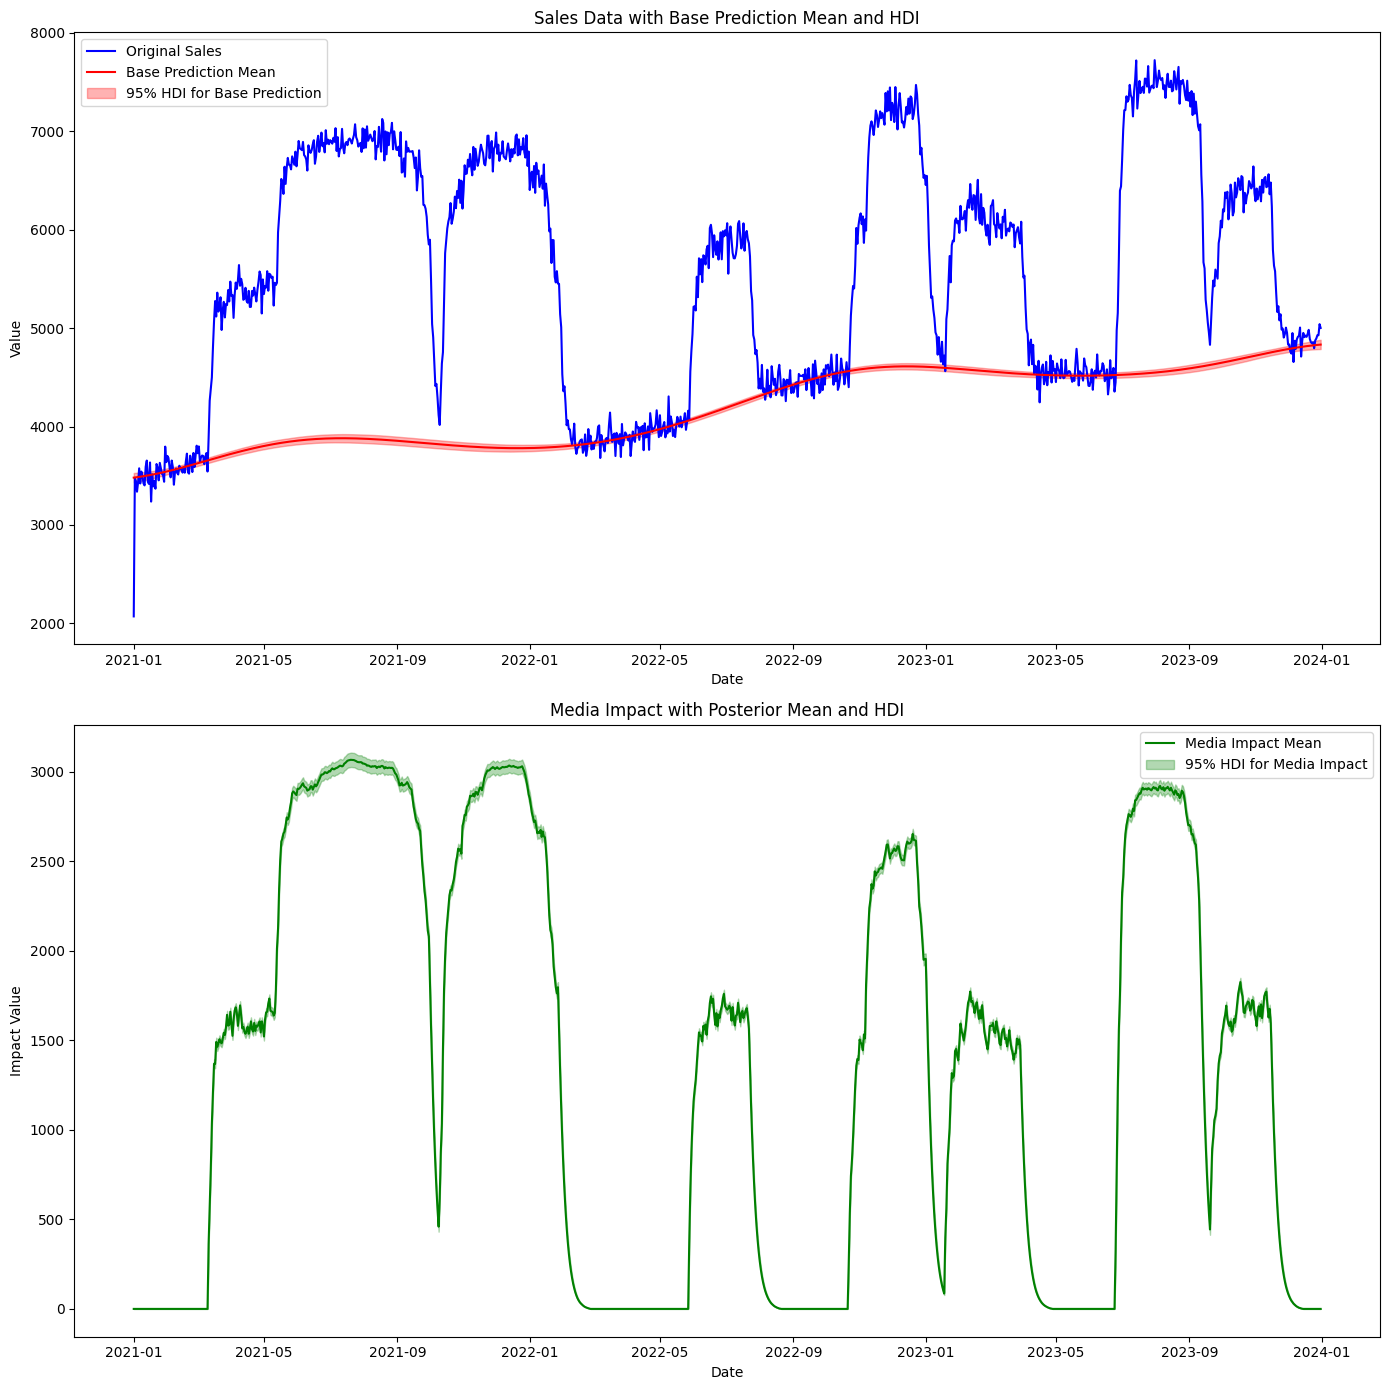

In [5]:
import matplotlib.pyplot as plt

# Compute the mean, lower, and upper HDI for "mu" across draws
base_mean = idata.posterior["base_prediction"].mean(dim=["draw", "chain"])
hdi_lower = idata.posterior["base_prediction"].quantile(0.025, dim=["draw", "chain"])
hdi_upper = idata.posterior["base_prediction"].quantile(0.975, dim=["draw", "chain"])

# Assuming you've also computed mean, lower, and upper HDI for media_impact
media_impact_mean = idata.posterior["media_impact"].mean(dim=["draw", "chain"])
media_impact_hdi_lower = idata.posterior["media_impact"].quantile(0.025, dim=["draw", "chain"])
media_impact_hdi_upper = idata.posterior["media_impact"].quantile(0.975, dim=["draw", "chain"])

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14))

# First Subplot: Sales Data with Base Prediction and HDI
ax1.plot(df['Date'], df['Sales'], label='Original Sales', color='blue')
ax1.plot(df['Date'], base_mean, label='Base Prediction Mean', color='red')
ax1.fill_between(df['Date'], hdi_lower, hdi_upper, color='red', alpha=0.3, label='95% HDI for Base Prediction')
ax1.set_xlabel('Date')
ax1.set_ylabel('Value')
ax1.set_title('Sales Data with Base Prediction Mean and HDI')
ax1.legend()


# Second Subplot: Media Impact
ax2.plot(df['Date'], media_impact_mean, label='Media Impact Mean', color='green')
ax2.fill_between(df['Date'], media_impact_hdi_lower, media_impact_hdi_upper, color='green', alpha=0.3, label='95% HDI for Media Impact')
ax2.set_xlabel('Date')
ax2.set_ylabel('Impact Value')
ax2.set_title('Media Impact with Posterior Mean and HDI')
ax2.legend()

plt.tight_layout()
plt.show()